# pyWRspice Wrapper Tutorial

### Intro

PyWRspice is Python wrapper for [WRspice](http://www.wrcad.com/), a SPICE simulation engine modified by Whiteley Research (WR) featuring Josephson junctions.

##### In the package:

- simulation.py: Simulate a complete or parametric WRspice script via WRspice simulator.
- script.py: Programmatically construct a WRspice script.
- remote.py: Run WRspice simulation remotely on an SSH server.

### Install WRspice

Get and install the software [here](http://www.wrcad.com/xictools/index.html).


*Important* : Make sure to take note where the executable wrspice is on your machine. 

On Unix, it is likely "/usr/local/xictools/bin/wrspice". 

On Windows, "C:/usr/local/xictools/bin/wrspice.bat".


In [1]:
# Add pyWRspice location to system path, if you haven't run setup.py
import sys
sys.path.append("../")

In [2]:
import numpy as np
import logging, importlib
from pyWRspice import script, simulation, remote

import matplotlib.pyplot as plt
%matplotlib inline
logging.basicConfig(level=logging.WARNING)

## 1. Run a complete WRspice script

Let's run a simple WRspice script.

**Requirements: **

- Declare the script with python format strings. 
- `write {output_file}` should be written by the script in the `.control` block, using the binary/text format.

In [3]:
script1 = """* Transient response of RLC circuit
.tran 50p 100n
* RLC model of a transmission line
R1 1 2 0.1
L1 2 3 1n
C1 3 0 20p
R2 3 0 1e3
* Load impedance
Rload 3 0 50
* Pulse voltage source
V1 1 0 pulse(0 1 1n 1n 1n 20n)
*
.control
run
set filetype=binary
write {output_file} v(2) v(3)
.endc
"""

#### Wrap the script into a WRWrapper class instance.

*Important*: Make sure to specify ```command = ``` path to the executable wrspice file on your machine. 

On Unix, it is likely ```/usr/local/xictools/bin/wrspice```.

On Windows, ```C:/usr/local/xictools/bin/wrspice.bat```.

In [4]:
engine = simulation.WRWrapper(command = "/usr/local/xictools/bin/wrspice") # Typical for Unix

# On Windows, try:
# sw = WRWrapper(command = "C:/usr/local/xictools/bin/wrspice.bat")

#### Run the script.

If you want to save the circuit file, specify the keyword argument ```circuit_file```. If you want to save the data file, specify ```output_file```. If not specified, temporary files will be created then deleted after execution.

The ```run``` method returns the output data.

In [5]:
dat1 = engine.run(script1)
# If you want to save the file, run: dat1 = engine.run(script1,circuit_file="dummy.cir",output_file="dummy.raw")

In [6]:
# Extract the data
ts = dat1.variables[0].values
v2 = dat1.variables[1].values
v3 = dat1.variables[2].values

In [7]:
# Or we can convert the data into pandas DataFrame object
df = dat1.to_df()
ts = df['time']
v2 = df['v(2)']
v3 = df['v(3)']

In [8]:
# Or we can convert the data into numpy array
df = dat1.to_array()
ts = df[0]
v2 = df[1]
v3 = df[2]

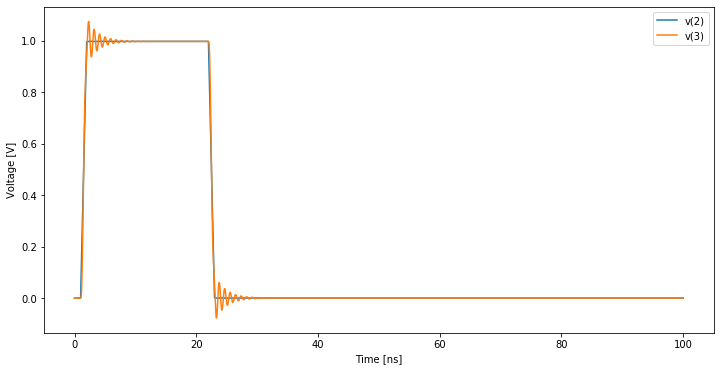

In [9]:
# Plot the data
fig = plt.figure(figsize=(12,6))
plt.plot(ts*1e9, v2, label="v(2)")
plt.plot(ts*1e9, v3, label="v(3)")
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.show()

## 2. Run a parametric WRspice script

We can parametrize the circuit description by using keyword substitution in Python string. Basically, if ```s = "Value={x}"``` then ```s.format(x=2)``` results in ```Value=2```.

In the example below, we parametrize the values of the capacitor as ```cap``` (pF) and pulse duration as ```dur``` (ns).

In [10]:
script2 = """* Transient response of RLC circuit
.tran 50p 100n

* RLC model of a transmission line
R1 1 2 0.1
L1 2 3 1n
C1 3 0 {cap}p
R2 3 0 1e3

* Load impedance
Rload 3 0 50

* Pulse voltage source
V1 1 0 pulse(0 1 1n 1n 1n {dur}n)
*
.control
run
set filetype=binary
write {output_file} v(2) v(3)
.endc
"""

sw = simulation.WRWrapper(script2, command = "/usr/local/xictools/bin/wrspice")

We then specify the values of ```cap``` and ```dur``` when execute the script with the ```run``` function.

In [11]:
dat2 = engine.run(script2,cap=30, dur=40)

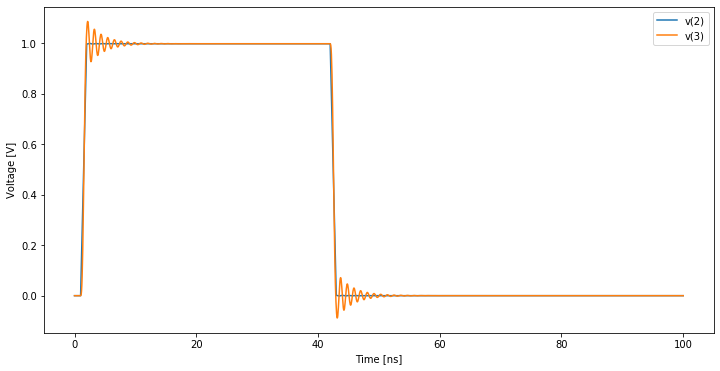

In [12]:
# Extract the data
dat2 = dat2.to_array()
ts = dat2[0]
v2 = dat2[1]
v3 = dat2[2]

# Plot the data
fig = plt.figure(figsize=(12,6))
plt.plot(ts*1e9, v2, label="v(2)")
plt.plot(ts*1e9, v3, label="v(3)")
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.show()

**Tip:** When there are many parameters, it is clumsy to pass them into the ```run()``` method. We can collect them into a dictionary object and pass it altogether to ```run()```. This makes it easier for verifying and changing values. As an example:

In [13]:
params = {'cap':30,
         'dur':40,
         'output_file':None}
# Check the script before running
print(script2.format(**params))

* Transient response of RLC circuit
.tran 50p 100n

* RLC model of a transmission line
R1 1 2 0.1
L1 2 3 1n
C1 3 0 30p
R2 3 0 1e3

* Load impedance
Rload 3 0 50

* Pulse voltage source
V1 1 0 pulse(0 1 1n 1n 1n 40n)
*
.control
run
set filetype=binary
write None v(2) v(3)
.endc



In [14]:
# Run the script by passing the params to the run() method
dat2 = engine.run(script2,**params)
# The results should be the same as the previous run. Not shown here.

## 3. Run WRspice script with multiple parametric values in parallel

We can pass a list of values to one or more parameters and run them all in parallel, using multiprocessing, with the ```run_parallel()``` method. Let's demonstrate it with ```cap```.

In [15]:
# Recycle params above
params["cap"] = [20,50,100]
params["dur"] = 40

params3, dat3 = engine.run_parallel(script2,**params)

The returned is an array of data corresponding to multiple runs. We need some extra work to extract them.

In [16]:
params3

{'cap': array([ 20,  50, 100])}

In [17]:
dat3

array([<pyWRspice.simulation.RawFile object at 0xa19bce1d0>,
       <pyWRspice.simulation.RawFile object at 0xa19bce208>], dtype=object)

In [18]:
# Extract data
caps = params3["cap"]
v3s = []
for dat in dat3:
    v3s.append(dat.to_array()[2])
ts = dat.to_array()[0]

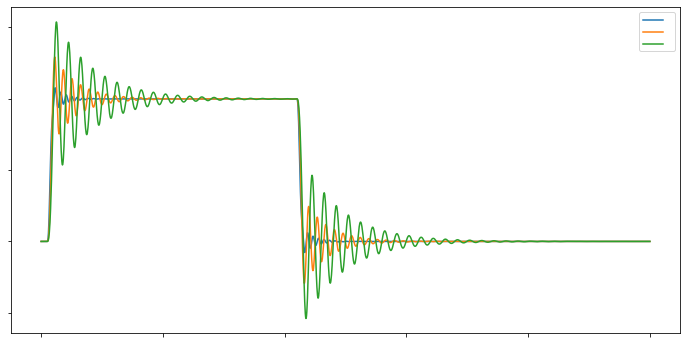

In [19]:
# Plot the data
fig = plt.figure(figsize=(12,6))
for cap,v3 in zip(caps,v3s):
    plt.plot(ts*1e9, v3, label="cap = %s pF" %cap)
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.show()

#### Parallel run with multiple parameters

We can change multiple parameters in one single parallel run. For example, repeat the above simulation with 2 different pulse durations.

In [15]:
# Recycle params above
params["cap"] = [20,50,100]
params["dur"] = [30, 60]

params4, dat4 = engine.run_parallel(script2,**params)

In [16]:
# Examine the returned parameter values
for k,v in params4.items():
    print("%s = %s" %(k,v))
    print("")

cap = [[ 20  20]
 [ 50  50]
 [100 100]]

dur = [[30 60]
 [30 60]
 [30 60]]



In [17]:
# Get the shape of the returned data
dat4.shape

(3, 2)

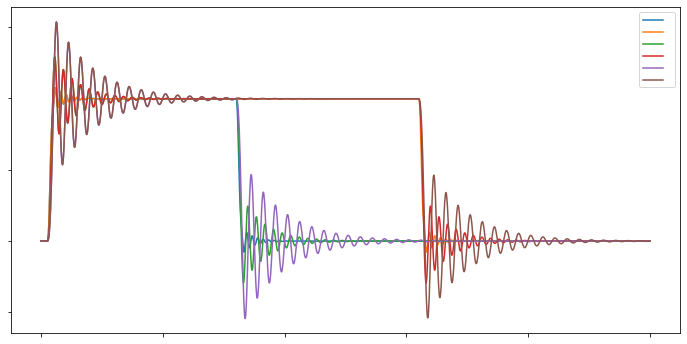

In [18]:
# Plot the data
fig = plt.figure(figsize=(12,6))
shape = dat4.shape
for i in range(shape[0]):
    for j in range(shape[1]):
        dat = dat4[i,j]
        ts = dat.variables[0].values
        v3 = dat.variables[2].values
        plt.plot(ts*1e9, v3, label="cap=%s[pF], dur=%s[ns]" %(params4["cap"][i,j],params4["dur"][i,j]))
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.show()

## 4. Adaptive run

Will be added later if there will be demand.

## 5. Construct a WRspice script using script.py

So far we have written the sample WRspice scripts manually. The task can become arduous for large circuits. One can use the template package ```jinja``` to ease the task. Here we explore a different, pythonic way, to construct ```script2``` above.

In [23]:
# Reminder: script2
print(script2)

* Transient response of RLC circuit
.tran 50p 100n

* RLC model of a transmission line
R1 1 2 0.1
L1 2 3 1n
C1 3 0 {cap}p
R2 3 0 1e3

* Load impedance
Rload 3 0 50

* Pulse voltage source
V1 1 0 pulse(0 1 1n 1n 1n {dur}n)
*
.control
run
set filetype=binary
write {output_file} v(2) v(3)
.endc



### Set up a circuit

We can declare a component by specifying its name, a list of ```ports```, ```value```, and additional parameters. ```ports``` can be numeric or string but, as with ```value```, will be converted to string eventually.

In [19]:
# Circuit components
R1 = script.Component("R1",ports=[1,"p2"],value=0.1,params={},comment="") # Full description
L1 = script.Component("L1",["p2",3],"1n")
C1 = script.Component("C1",[L1.ports[1],0],"{cap}p")
R2 = script.Component("R2",[3,0],1e3)

In [20]:
# Set up a circuit
cir = script.Circuit()
# Add components to the circuit
cir.add_component(R1) # Add one component
cir.add_components([L1,C1,R2]) # Add a list of components
# Display the circuit
print(cir.script())

R1 1 2 0.1
L1 2 3 1n
C1 3 0 {cap}p
R2 3 0 1000.0


/Users/mnguyen/Documents/Software/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


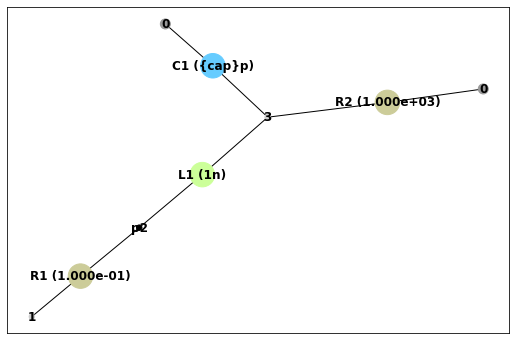

In [21]:
# Plot the circuit, showing value
plt.figure(figsize=(9,6))
cir.plot(show_value=True)
plt.show()

In [22]:
# Similarly, set up a circuit having the load resistance and voltage source
Rload = script.Component("Rload",[3,0],50, comment="Load resistance")
V1 = script.Component("V1",[1,0],"pulse(0 1 1n 1n 1n {dur}n)", comment="Pulse source")

control_cir = script.Circuit()
control_cir.add_components([Rload,V1])
print(control_cir.script())

* Load resistance
Rload 1 0 50
* Pulse source
V1 2 0 pulse(0 1 1n 1n 1n {dur}n)


We can add models by ```add_model()```, subcircuits by ```add_subcircuit()``` or add extra script by ```add_script()``` into the circuit object. Let's skip these for now.

### Set up a script

In [23]:
scr = script.Script("Transient response of RLC circuit")

In [24]:
# Add circuits
scr.add_circuit(cir)
scr.add_circuit(control_cir)

In [27]:
# Specify analysis and data saving
scr.analysis = ".tran 50p 100n"
scr.config_save(["p2",3],filename=None,filetype="binary") # specify which voltages to save; filename and filetype are optional

*Transient response of RLC circuit
.tran 50p 100n
R1 1 2 0.1
L1 2 3 1n
C1 3 0 {cap}p
R2 3 0 1000.0
* Load resistance
Rload 1 0 50
* Pulse source
V1 2 0 pulse(0 1 1n 1n 1n {dur}n)
.control
run
set filetype=binary
write {output_file} v(2) v(3)
.endc


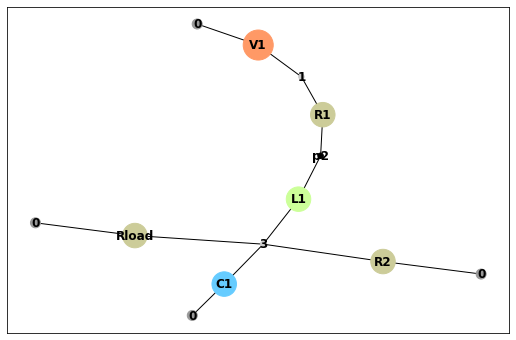

In [28]:
# Print out the script
print(scr.script())

# For confirmation, plot the combined circuit
plt.figure(figsize=(9,6))
scr.plot()
plt.show()

Note: We use string ```p2``` to declare a port, but when converting to a true SPICE script, all ports are converted to numeric ones. In this case, ```p2``` is assigned to ```2```.

#### Test run the script

In [29]:
# Get the circuit parameters
scr.get_params()
print(scr.params)

{'cap': '', 'dur': '', 'output_file': ''}


In [30]:
# Set values to the parameters
scr.params["cap"] = 100
scr.params["dur"] = 40
# Alternatively
scr.set_params(cap=100,dur=40)

# Run the script
dat5 = engine.run(scr.script(),**scr.params)

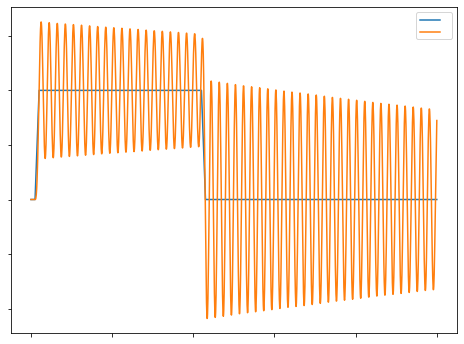

In [32]:
# Extract the data
dat5 = dat5.to_array()
ts = dat5[0]
v2 = dat5[1]
v3 = dat5[2]

# Plot the data
fig = plt.figure(figsize=(8,6))
plt.plot(ts*1e9, v2, label="v(2)")
plt.plot(ts*1e9, v3, label="v(3)")
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.show()

### Add an array of components

Adding an array of components or subcircuits into a circuit is now very simple. Let's use ```cir``` as a subcircuit modelling a segment of a transmission line. We will simulate 10 of them.

In [33]:
big_cir = script.Circuit()
# Add subcircuit
big_cir.add_subcircuit(cir,"segment",[1,3])
print(big_cir.script())

.subckt segment 1 3
R1 1 2 0.1
L1 2 3 1n
C1 3 0 {cap}p
R2 3 0 1000.0
.ends segment


In [34]:
# The subcircuit can be instantiated as a general component whose name starts with 'X'
# Let's add 10 of them
for i in range(1,11):
    big_cir.add_component(script.Component("X%d"%i,[i,i+1],"segment"))
# Check the result
print(big_cir.script())

.subckt segment 1 3
R1 1 2 0.1
L1 2 3 1n
C1 3 0 {cap}p
R2 3 0 1000.0
.ends segment
X1 1 2 segment
X2 2 3 segment
X3 3 4 segment
X4 4 5 segment
X5 5 6 segment
X6 6 7 segment
X7 7 8 segment
X8 8 9 segment
X9 9 10 segment
X10 10 11 segment


In [35]:
# Add the source and load
Rload.ports = [11,0] # Change the ports of Rload, originally [3,0]
big_cir.add_components([V1,Rload])

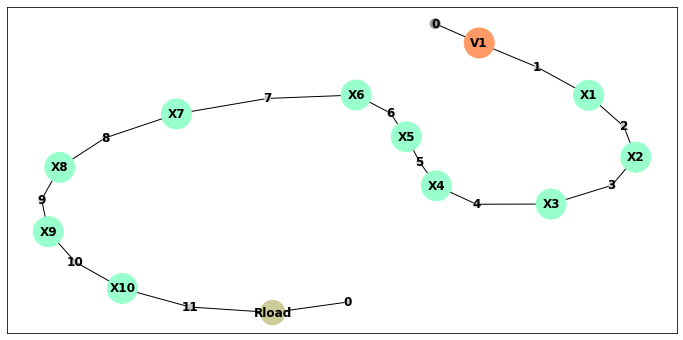

In [36]:
# Plot the circuit, not show value
plt.figure(figsize=(12,6))
big_cir.plot()
plt.show()

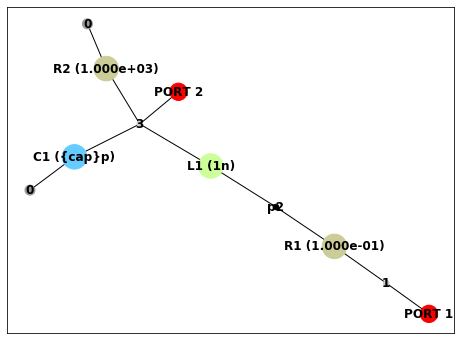

In [37]:
# In case we forgot how the subcircuit looks like, let's plot it again
plt.figure(figsize=(8,6))
big_cir.subcircuits["segment"].plot(show_value=True)
plt.show()

In [38]:
# Set up a script
scr2 = script.Script("Transient response of a transmission line")

In [39]:
# Add circuits
scr2.add_circuit(big_cir)
# Specify analysis and data saving
scr2.analysis = ".tran 50p 100n"
scr2.config_save([1,5,11]) # Just examine a few voltages

In [40]:
# Final check of the script
print(scr2.script())

*Transient response of a transmission line
.tran 50p 100n
.subckt segment 1 3
R1 1 2 0.1
L1 2 3 1n
C1 3 0 {cap}p
R2 3 0 1000.0
.ends segment
X1 1 2 segment
X2 2 3 segment
X3 3 4 segment
X4 4 5 segment
X5 5 6 segment
X6 6 7 segment
X7 7 8 segment
X8 8 9 segment
X9 9 10 segment
X10 10 11 segment
* Pulse source
V1 1 0 pulse(0 1 1n 1n 1n {dur}n)
* Load resistance
Rload 11 0 50
.control
run
set filetype=binary
write {output_file} v(1) v(5) v(11)
.endc


In [41]:
# Get the circuit parameters
scr2.get_params()

{'cap': '', 'dur': '', 'output_file': ''}

In [42]:
# Set values to the parameters
scr2.set_params(cap=100,dur=40)
# Run the script
dat5 = engine.run(scr2.script(),**scr2.params)

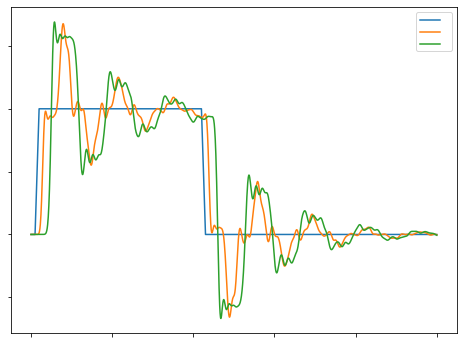

In [43]:
# Extract the data
df5 = dat5.to_df()
ts = df5["time"]
vs = df5["v(1)"]
vmid = df5["v(5)"]
vload = df5["v(11)"]

# Plot the data
fig = plt.figure(figsize=(8,6))
plt.plot(ts*1e9, vs, label="V source")
plt.plot(ts*1e9, vmid, label="V mid")
plt.plot(ts*1e9, vload, label="V load")
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.show()